# Workflow

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import sys

sys.path.append('../hydra_tod/')

from astropy.coordinates import EarthLocation, AltAz, SkyCoord
from astropy.time import Time, TimeDelta
import astropy.units as u
from utils import Leg_poly_proj, view_samples
from flicker_model import sim_noise, flicker_cov
from simulation import * 

In [2]:
# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator

# Then import from noise_sampler_fixed_fc
from noise_sampler_fixed_fc import flicker_noise_sampler, flicker_likeli_func

Using the emulator for flicker noise correlation function.


In [3]:
# Load the simulation results
import pickle
from simulation import TODSimulation

with open('tod_simulation_single.pkl', 'rb') as f:
    tod_sim = pickle.load(f)


In [4]:
sky_params = tod_sim.sky_params
nd_rec_params = tod_sim.nd_rec_params
gain_params_setting = tod_sim.gain_params_setting
calibration_indices = tod_sim.calibration_1_indice
alpha = tod_sim.alpha

TOD_setting = tod_sim.TOD_setting
t_list = tod_sim.t_list
gain_proj = tod_sim.gain_proj
Tsky_operator_setting = tod_sim.Tsky_operator_setting
nd_rec_operator = tod_sim.nd_rec_operator

logfc = tod_sim.logfc

# Additional variables needed for the analysis
pixel_indices = tod_sim.pixel_indices
nside = tod_sim.nside
f0 = tod_sim.f0
T_ndiode = tod_sim.T_ndiode
rec_params = tod_sim.rec_params
logf0_list = [tod_sim.logf0]  # Convert to list format as expected later

In [5]:
gain_params_setting

array([6.31194264, 0.42038942, 0.264222  , 0.05578821])

In [6]:
init_Tsys_params = np.hstack([sky_params, nd_rec_params])
init_noise_params = [-4.8, 2.2]

gain_prior_cov_inv = np.zeros(4)
# prior_std_frac = 1
# gain_prior_cov_inv = 1. / (prior_std_frac * gain_params_setting)**2  # Prior STD ~100%
gain_prior_cov_inv[0] = 2.51 # DC mode: Prior STD ~10%
gain_prior_mean = gain_params_setting

prior_std_frac = 0.1
Tsky_prior_cov_inv = 1. / (prior_std_frac * sky_params)**2
Tsky_prior_cov_inv[calibration_indices] = 1e20

aux = np.ones_like(nd_rec_params)*0.0
aux[0] = 1
Trec_prior_cov_inv = [aux] # Effectlively no prior


In [ ]:
# Import the FlickerCorrEmulator class first
from flicker_model import FlickerCorrEmulator
from full_Gibbs_sampler import full_Gibbs_sampler_multi_TODS_v2

Tsys_samples, all_gain_samples, all_noise_samples = \
    full_Gibbs_sampler_multi_TODS_v2([TOD_setting],
                                    [t_list],
                                    [gain_proj],
                                    [Tsky_operator_setting],
                                    [nd_rec_operator],
                                    init_Tsys_params,
                                    init_noise_params, 
                                    [logfc],
                                    num_Jeffrey=False,
                                    wnoise_var=2.5e-6,
                                    Tsky_prior_cov_inv=Tsky_prior_cov_inv,
                                    Tsky_prior_mean=sky_params,
                                    local_Trec_prior_cov_inv_list=Trec_prior_cov_inv,
                                    local_Trec_prior_mean_list=[nd_rec_params],
                                    local_gain_prior_cov_inv_list=[gain_prior_cov_inv],
                                    local_gain_prior_mean_list=[gain_prior_mean],
                                    #local_noise_prior_func_list=[log_prior_noise, log_prior_noise],
                                    n_samples=10000,
                                    tol=1e-20,
                                    Est_mode=False)

# First, save the samples as npy files..

np.save("outputs/GS1/Tsys_samples_1e4.npy", Tsys_samples)
np.save("outputs/GS1/gain_samples_1e4.npy", np.concatenate(all_gain_samples, axis=0))
np.save("outputs/GS1/noise_samples_1e4.npy", np.concatenate(all_noise_samples, axis=0))

In [8]:
from MCMC_diagnostics import diagnostics

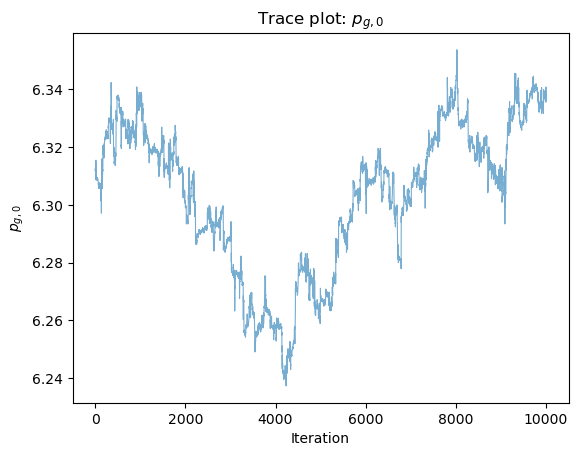

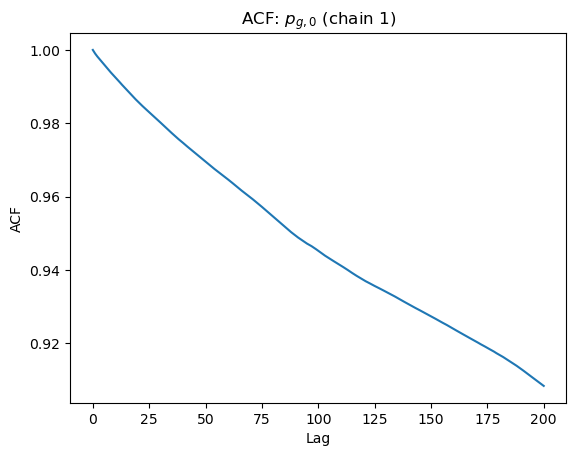

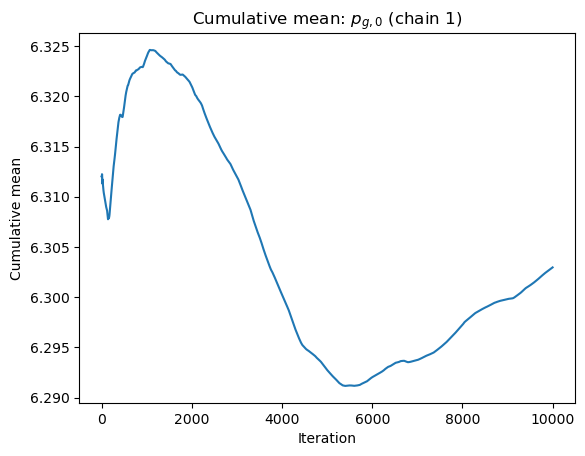

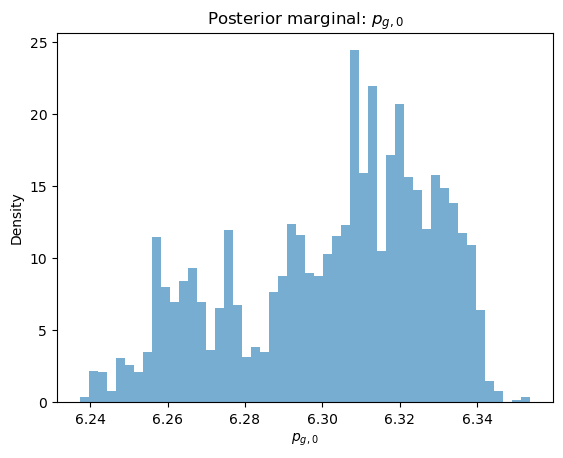

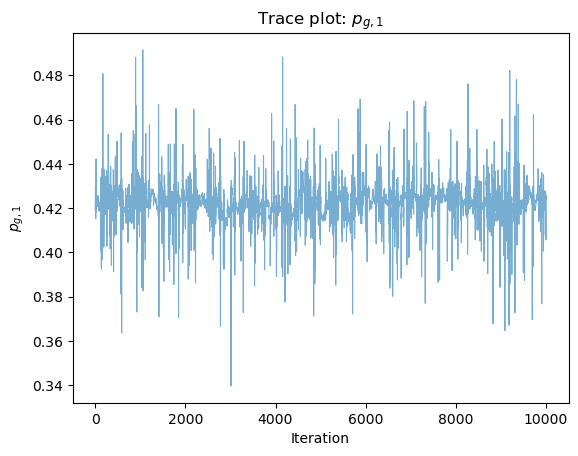

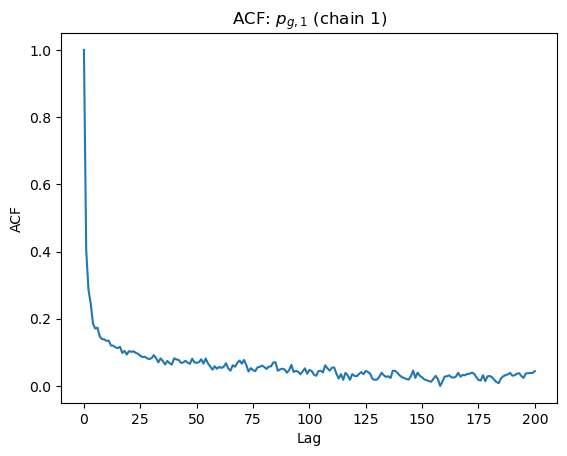

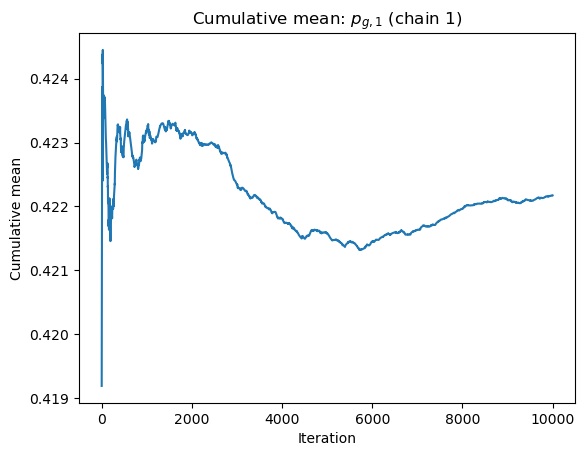

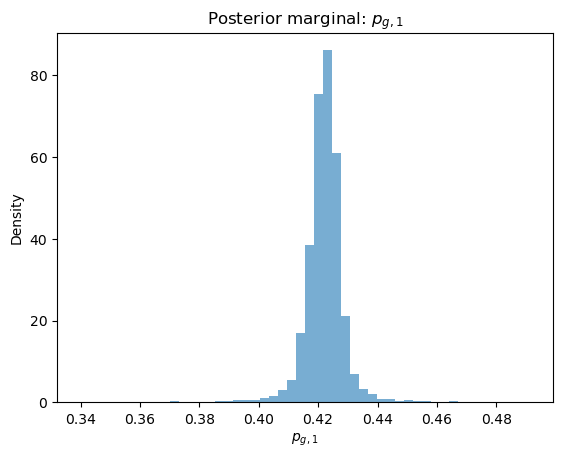

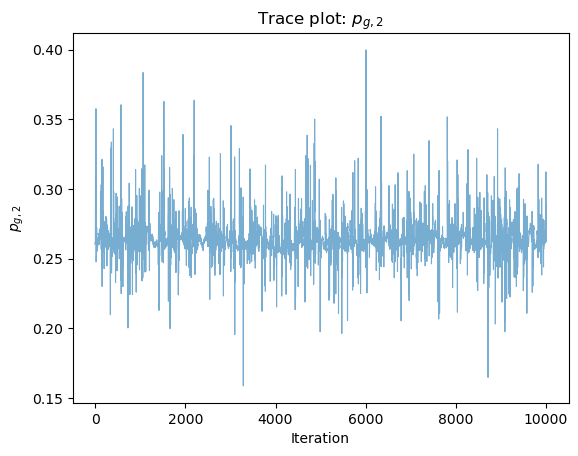

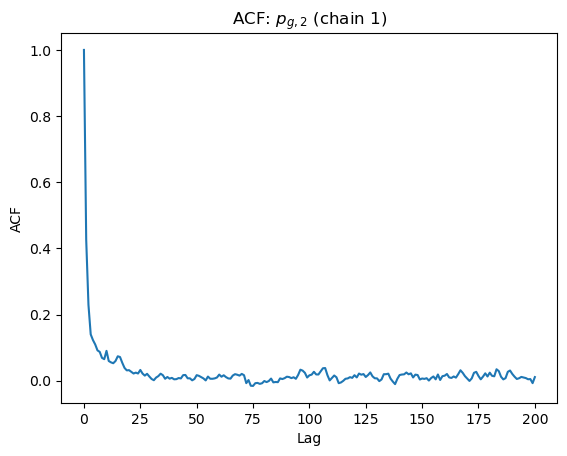

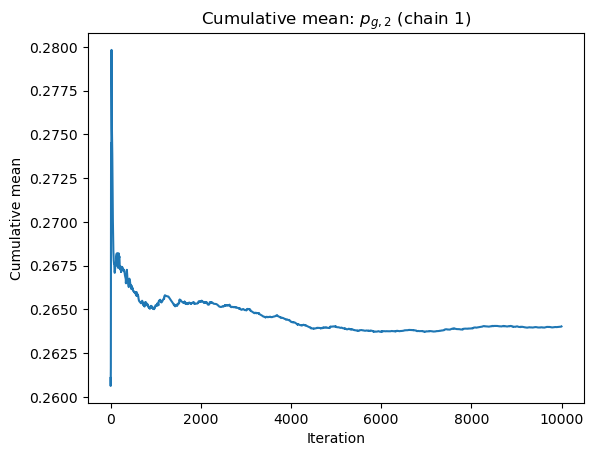

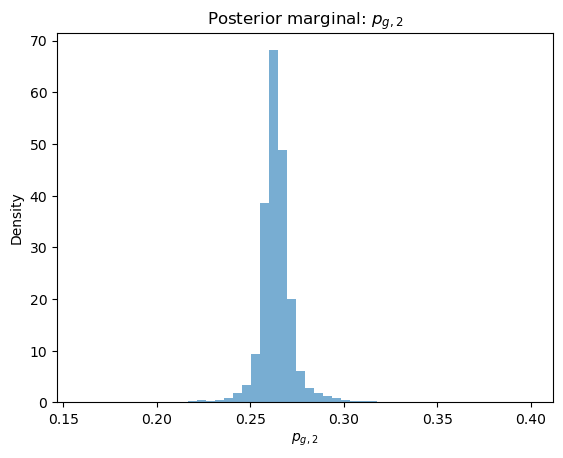

{'$p_{g,0}$': {'ESS_min': 4.385964320698257,
  'ESS_median': 4.385964320698257,
  'Rhat_split': 1.174851034385282},
 '$p_{g,1}$': {'ESS_min': 184.4583312591175,
  'ESS_median': 184.4583312591175,
  'Rhat_split': 1.007088368353538},
 '$p_{g,2}$': {'ESS_min': 1613.123017628885,
  'ESS_median': 1613.123017628885,
  'Rhat_split': 0.9999030113609629},
 '$p_{g,3}$': {'ESS_min': 2086.37798502207,
  'ESS_median': 2086.37798502207,
  'Rhat_split': 0.9999017838677975}}

In [9]:
diagnostics(all_gain_samples[0], param_names=[r"$p_{g,0}$", r"$p_{g,1}$",r"$p_{g,2}$",r"$p_{g,3}$"])